<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="ffffff">
Resnet code

</font>
</h1>

pariya branch

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [14]:
# set common data augmentation parameters
data_augmentation = ImageDataGenerator(###
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# load training data
train_ds = data_augmentation.flow_from_directory(
    r'E:\projectDataset\archive\sl_train',
    class_mode='categorical',
    target_size=(224,224),####
    shuffle=True,
    batch_size=32
)

# load testing data
test_ds = ImageDataGenerator(preprocessing_function=resnet_preprocess_input).flow_from_directory(
    r'E:\projectDataset\archive\sl_test',
    class_mode='categorical',
    target_size=(224,224),
    shuffle=False,
    batch_size=32
)

# load validation data
val_ds = ImageDataGenerator(preprocessing_function=resnet_preprocess_input).flow_from_directory(
    r'E:\projectDataset\archive\sl_valid',
    class_mode='categorical',
    target_size=(224,224),
    shuffle=True,
    batch_size=32
)

Found 2907 images belonging to 12 classes.
Found 1166 images belonging to 12 classes.
Found 1420 images belonging to 12 classes.


In [15]:

# load ResNet50 pre-trained model
base_model = ResNet50(weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False)

# set base model to trainable
base_model.trainable = True

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [16]:
fine_tune_at = 140

# freeze layers before fine-tune layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [20]:
# build classification model on top of ResNet50
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(12, activation='softmax'))

# print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)               

In [23]:

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [25]:

# set early stopping callback to prevent overfitting
early_stopping = EarlyStopping(patience=10)
model_checkpoint = ModelCheckpoint(
    "../my_checkpoint1", save_best_only=True)

# fine-tune the model
history = model.fit(
    train_ds,
    batch_size=32,
    epochs=5,
    #epochs=27,
    validation_data=val_ds,
  #  initial_epoch=22,
    callbacks=[early_stopping,model_checkpoint]
)

Epoch 1/5
91/91 [==============================] - 1063s 11s/step - loss: 0.9841 - accuracy: 0.7595 - val_loss: 9.5488 - val_accuracy: 0.6056
INFO:tensorflow:Assets written to: ..\my_checkpoint1\assets
Epoch 2/5
91/91 [==============================] - 1017s 11s/step - loss: 0.8380 - accuracy: 0.7840 - val_loss: 11.0170 - val_accuracy: 0.7007
Epoch 3/5
91/91 [==============================] - 863s 10s/step - loss: 0.9213 - accuracy: 0.8036 - val_loss: 2.5633 - val_accuracy: 0.7887
INFO:tensorflow:Assets written to: ..\my_checkpoint1\assets
Epoch 4/5
91/91 [==============================] - 832s 9s/step - loss: 1.2114 - accuracy: 0.7578 - val_loss: 4.0910 - val_accuracy: 0.7514
Epoch 5/5
91/91 [==============================] - 833s 9s/step - loss: 0.7654 - accuracy: 0.8005 - val_loss: 3.4444 - val_accuracy: 0.7866


In [26]:
test_loss, test_accuracy = model.evaluate(test_ds)#, steps=len(test_ds)/2
print('Accuracy on test dataset:', test_accuracy)

37/37 [==============================] - 152s 4s/step - loss: 6.7350 - accuracy: 0.7178
Accuracy on test dataset: 0.7178387641906738


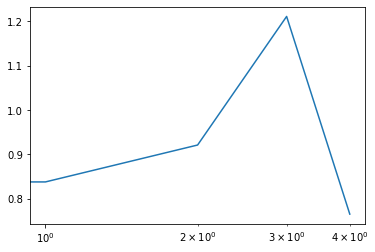

In [27]:
plt.semilogx( history.history["loss"])

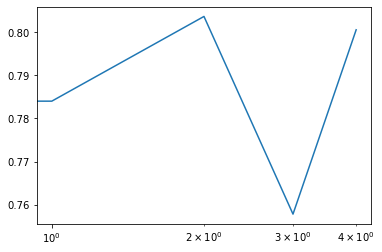

In [28]:
plt.semilogx( history.history["accuracy"])

In [29]:
model.save('../models/fruit_disease_classifier_resnet_FT_10.h5')